In [1]:
!python3 -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 81.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import re
import time
import math
import random
import ast
import numpy as np
import pandas as pd
import spacy
import ru_core_news_sm

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from typing import Tuple
from tqdm import tqdm

import torch.optim as optim
from torch import Tensor
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# from seq2seq_attention.visualize_attention import get_attention_frames

from tqdm import notebook
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
from torchtext.vocab import vocab
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
import seaborn as sns
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import ast  # To convert string representation of list to actual list
# Example usage of Word2Vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import nltk
nltk.download('punkt')  # Ensure that the Punkt tokenizer models are downloaded

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [4]:
df = pd.read_csv("/content/gdrive/MyDrive/tokenizer_data.csv")

In [5]:
df

Unnamed: 0  \
0                0   
1                1   
2                2   
3                3   
4                4   
...            ...   
496054      496054   
496055      496055   
496056      496056   
496057      496057   
496058      496058   

                                                                                                                                                                                                        English  \
0                                                                                                                                                                                                        ['go']   
1                                                                                                                                                                                                        ['go']   
2                                                                                                                                                                                                        ['go']   
3                                                                                                                                                                                                        ['hi']   
4                                                                                                                                                                                                        ['hi']   
...                                                                                                                                                                                                         ...   
496054  ['at', 'a', 'moment', 'when', 'our', 'economy', 'is', 'growing', ' ', 'our', 'businesses', 'are', 'creating', 'jobs', 'at', 'the', 'fastest', 'pace', 'since', 'the', '1990s', ' ', 'and', 'wages', ...   
496055  ['when', 'i', 'was', 'younger', ' ', 'i', 'hated', 'going', 'to', 'weddings', ' ', 'my', 'grandmothers', 'and', 'aunts', 'would', 'huddle', 'around', 'me', ' ', 'poke', 'me', 'in', 'the', 'side', ...   
496056  ['since', 'there', 'are', 'usually', 'multiple', 'websites', 'on', 'any', 'given', 'topic', ' ', 'i', 'usually', 'just', 'click', 'the', 'back', 'button', 'when', 'i', 'arrive', 'on', 'any', 'webp...   
496057  ['if', 'someone', 'who', 'doesn', 't', 'know', 'your', 'background', 'says', 'that', 'you', 'sound', 'like', 'a', 'native', 'speaker', ' ', 'it', 'means', 'they', 'probably', 'noticed', 'something...   
496058  ['doubtless', 'there', 'exists', 'in', 'this', 'world', 'precisely', 'the', 'right', 'woman', 'for', 'any', 'given', 'man', 'to', 'marry', 'and', 'vice', 'versa', ' ', 'but', 'when', 'you', 'consi...   

                                                                                                                                                                                                        Russian  
0                                                                                                                                                                                                      ['марш']  
1                                                                                                                                                                                                       ['иди']  
2                                                                                                                                                                                                     ['идите']  
3                                                                                                                                                                                              ['здравствуйте']  
4                                                                                                                                                               

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Load the Russian model
rus_tokenizer = spacy.load("ru_core_news_sm")

# Load the English model
eng_tokenizer = spacy.load("en_core_web_sm")

In [8]:
def tokenize_russian(text):
  return [tok.text for tok in rus_tokenizer.tokenizer(text)]

# Tokenizes English text from a string into a list of tokens
def tokenize_en(text):
  return [tok.text for tok in eng_tokenizer.tokenizer(text)]

In [9]:
def preprocess_and_tokenize(df, column):
    # Process text into a format suitable for Word2Vec training
    all_sentences = []

    for text in df[column]:
        # Convert from string representation of list to list
        text = ast.literal_eval(text)

        # Convert list to string
        text = ' '.join(text).lower()

        # Preprocess text
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces

        # Tokenize text into sentences and then words
        sentences = nltk.sent_tokenize(text)
        word_lists = [nltk.word_tokenize(sentence) for sentence in sentences]
        all_sentences.extend(word_lists)

    return all_sentences

# Apply the function to both English and Russian columns
english_sentences = preprocess_and_tokenize(df, 'English')
russian_sentences = preprocess_and_tokenize(df, 'Russian')


# Train Word2Vec model on English data
english_model = Word2Vec(english_sentences, min_count=1, sg=0, window=2)

# Train Word2Vec model on Russian data
russian_model = Word2Vec(russian_sentences, min_count=1, sg=0, window=2)

print("English model vocabulary size:", len(english_model.wv))
print("Russian model vocabulary size:", len(russian_model.wv))


English model vocabulary size: 17572
Russian model vocabulary size: 60038


In [10]:
print(english_model)

Word2Vec<vocab=17572, vector_size=100, alpha=0.025>


In [11]:
print(russian_model)

Word2Vec<vocab=60038, vector_size=100, alpha=0.025>


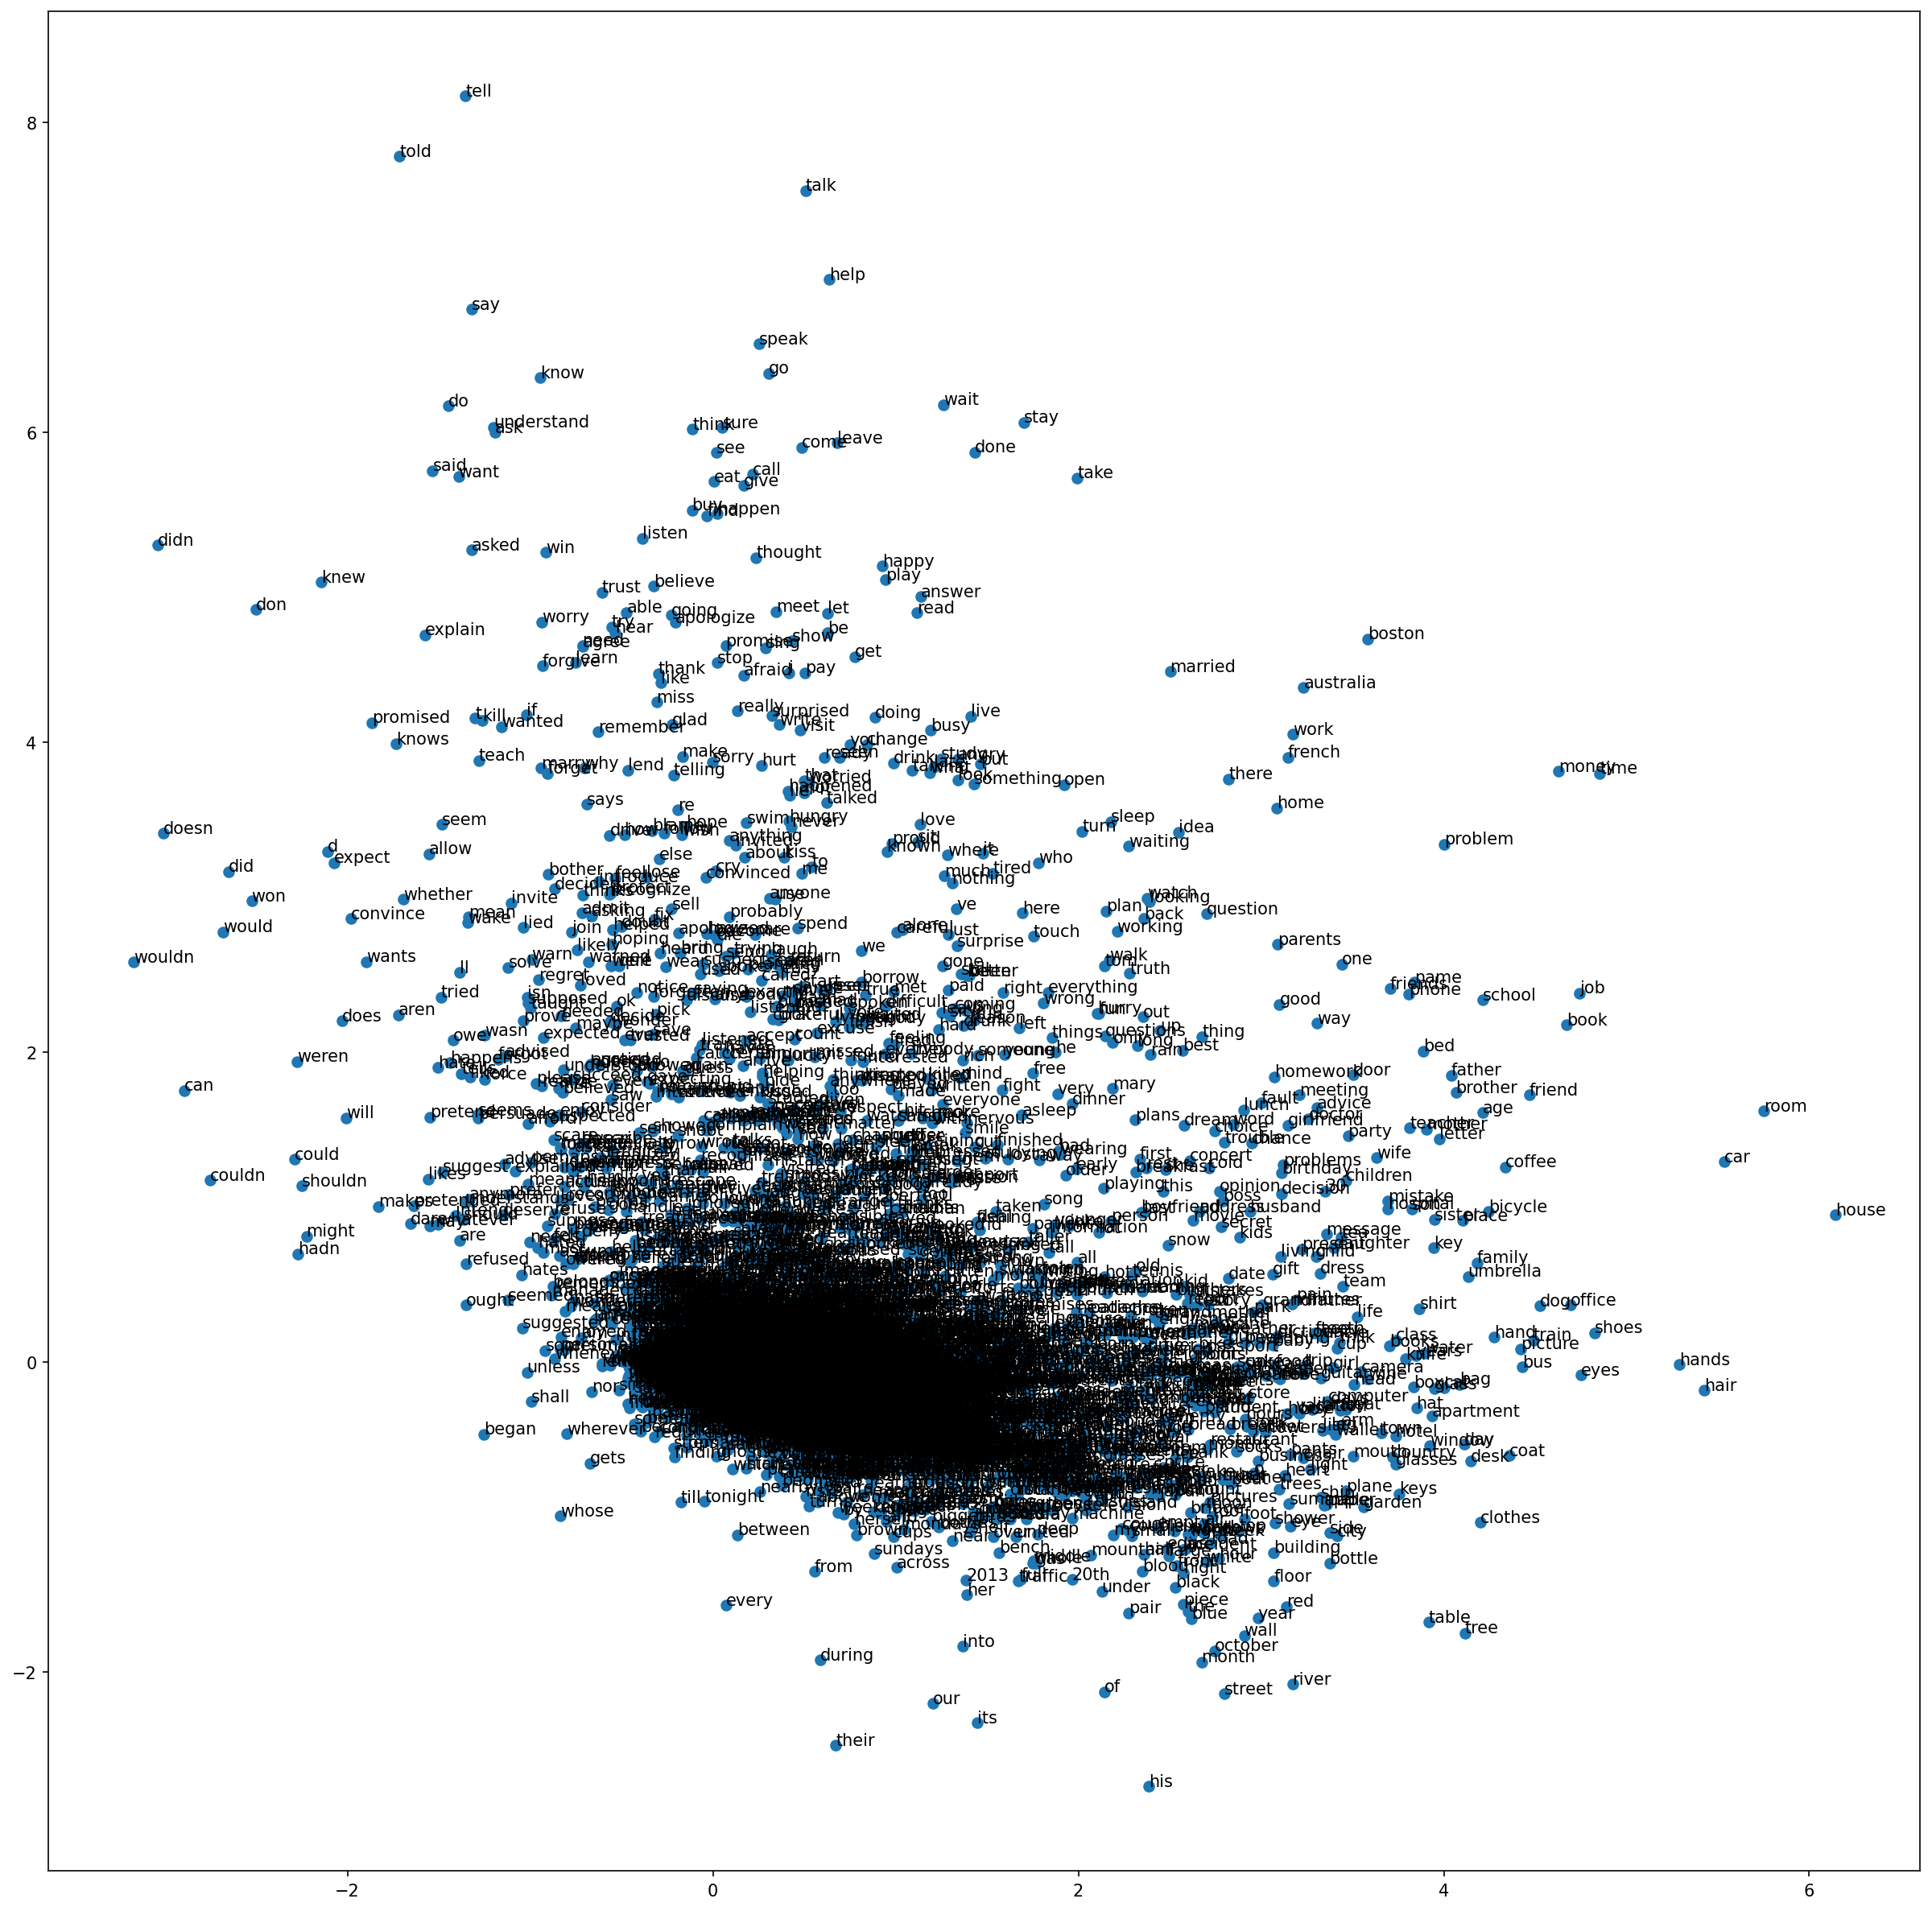

In [37]:
X = english_model.wv[english_model.wv.key_to_index.keys()]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(20, 20), dpi=150)
plt.scatter(result[:, 0], result[:, 1])
words = list(english_model.wv.key_to_index.keys())
for i, word in enumerate(words):
 plt.annotate(word, xy=(result[i, 0], result[i, 1]))

# Save the plot as an image file
plt.savefig("word_embeddings_plot_English.png")
plt.show()

In [38]:
df.English

0                                                                                                                                                                                                          ['go']
1                                                                                                                                                                                                          ['go']
2                                                                                                                                                                                                          ['go']
3                                                                                                                                                                                                          ['hi']
4                                                                                                                                                               

In [40]:
selected_word = "promised"
similar_words = english_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

outgoing 0.770688533782959
addictive 0.757549524307251
decisive 0.7568835020065308
conscientious 0.7560781836509705
secretive 0.7555627822875977
uptight 0.7525776624679565
insistent 0.7508483529090881
bland 0.7500735521316528
cheerful 0.7450305819511414
evasive 0.7449120283126831


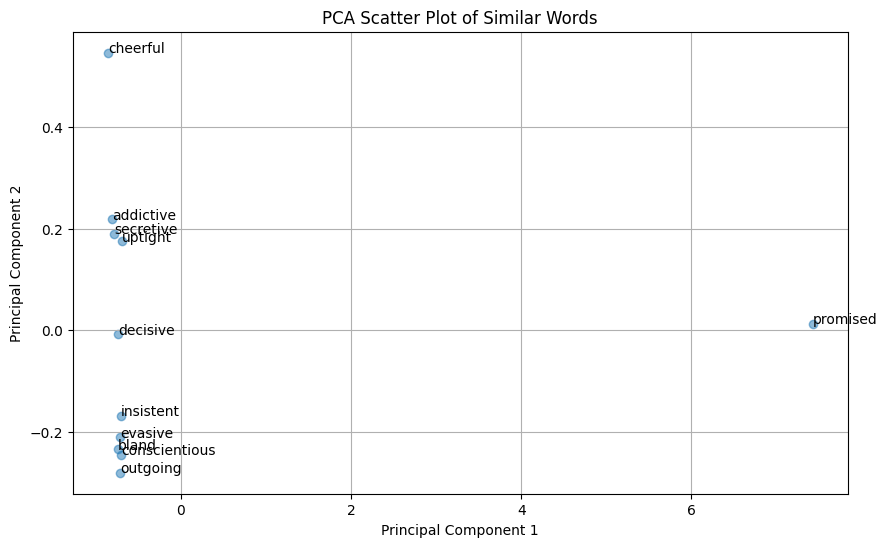

In [42]:
word_embeddings = [english_model.wv[word] for word, _ in similar_words]
word_embeddings.append(english_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()

In [43]:
selected_word = "married"
similar_words = english_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

hoped 0.7382163405418396
told 0.6871367692947388
advise 0.6633660197257996
advised 0.6551021337509155
swore 0.6383193135261536
warned 0.6297855973243713
asked 0.6160908341407776
persuaded 0.6156613826751709
decided 0.5924459099769592
begged 0.5880448818206787


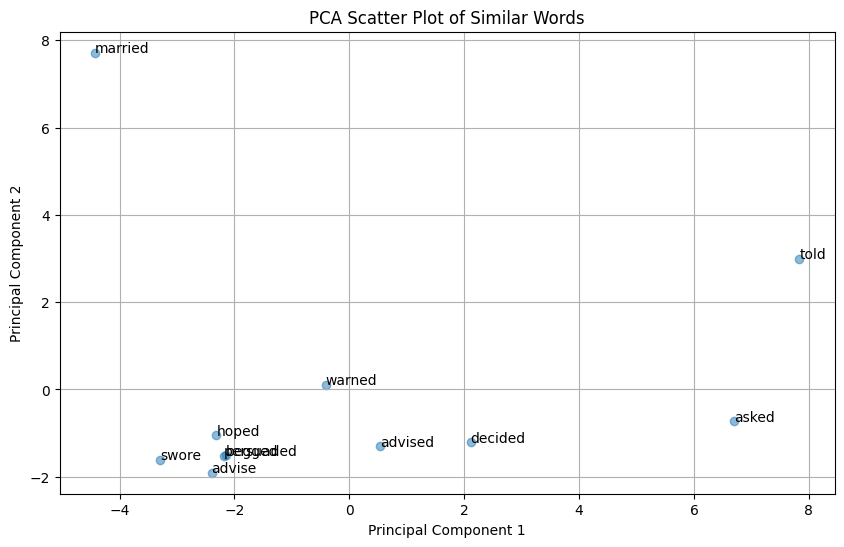

In [44]:
word_embeddings = [english_model.wv[word] for word, _ in similar_words]
word_embeddings.append(english_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()

In [53]:
selected_word = "businesses"
similar_words = english_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

differences 0.8007264733314514
difficulties 0.7990168333053589
possibilities 0.7982159852981567
schools 0.7949114441871643
resources 0.7937922477722168
rooms 0.7908780574798584
shops 0.7869158983230591
wives 0.7835140824317932
beds 0.7801899313926697
obstacles 0.7769955992698669


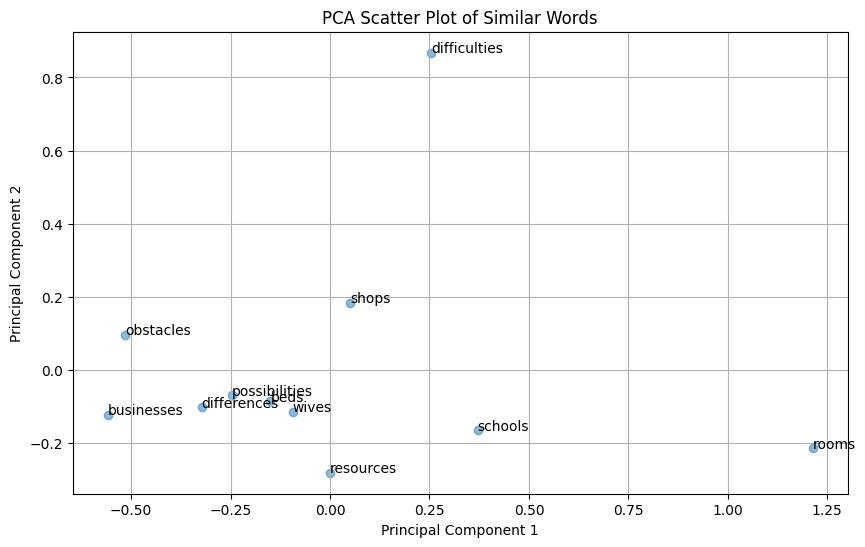

In [54]:
word_embeddings = [english_model.wv[word] for word, _ in similar_words]
word_embeddings.append(english_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()

In [59]:
selected_word = "economy"
similar_words = english_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

nation 0.8203608393669128
site 0.8046184182167053
investigation 0.8039073944091797
universe 0.800433337688446
author 0.7851282358169556
crisis 0.7777897715568542
infection 0.775951087474823
victory 0.775551438331604
victims 0.775230348110199
champion 0.7715191841125488


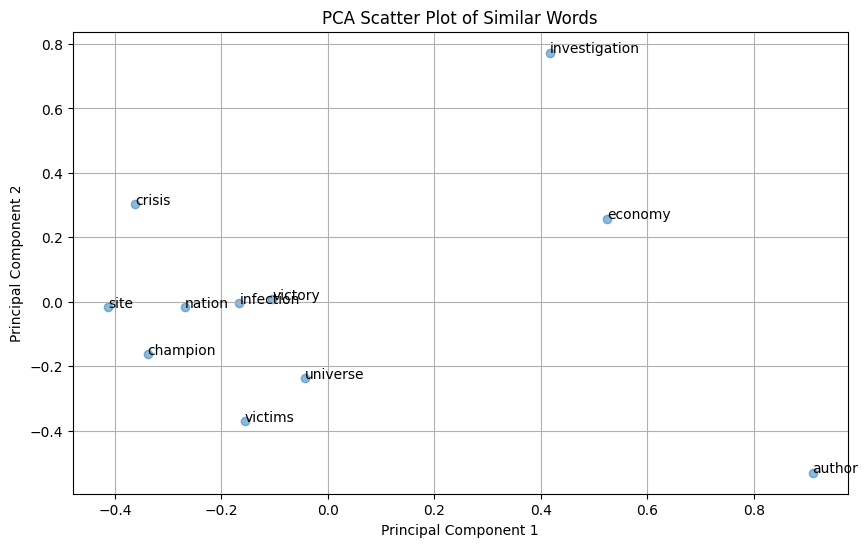

In [60]:
word_embeddings = [english_model.wv[word] for word, _ in similar_words]
word_embeddings.append(english_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()

In [78]:
selected_word = "jobs"
similar_words = english_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

minds 0.815945029258728
umbrellas 0.812951385974884
opinions 0.8111389875411987
hats 0.7749372124671936
goals 0.7747944593429565
pencils 0.7736475467681885
tools 0.7679064869880676
trousers 0.7626329064369202
weapons 0.7580137252807617
customers 0.7575855255126953


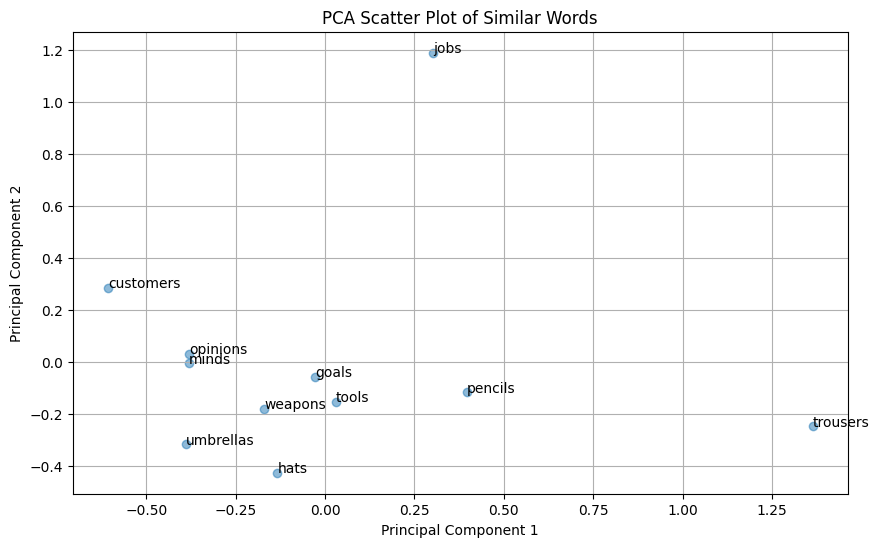

In [79]:
word_embeddings = [english_model.wv[word] for word, _ in similar_words]
word_embeddings.append(english_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()

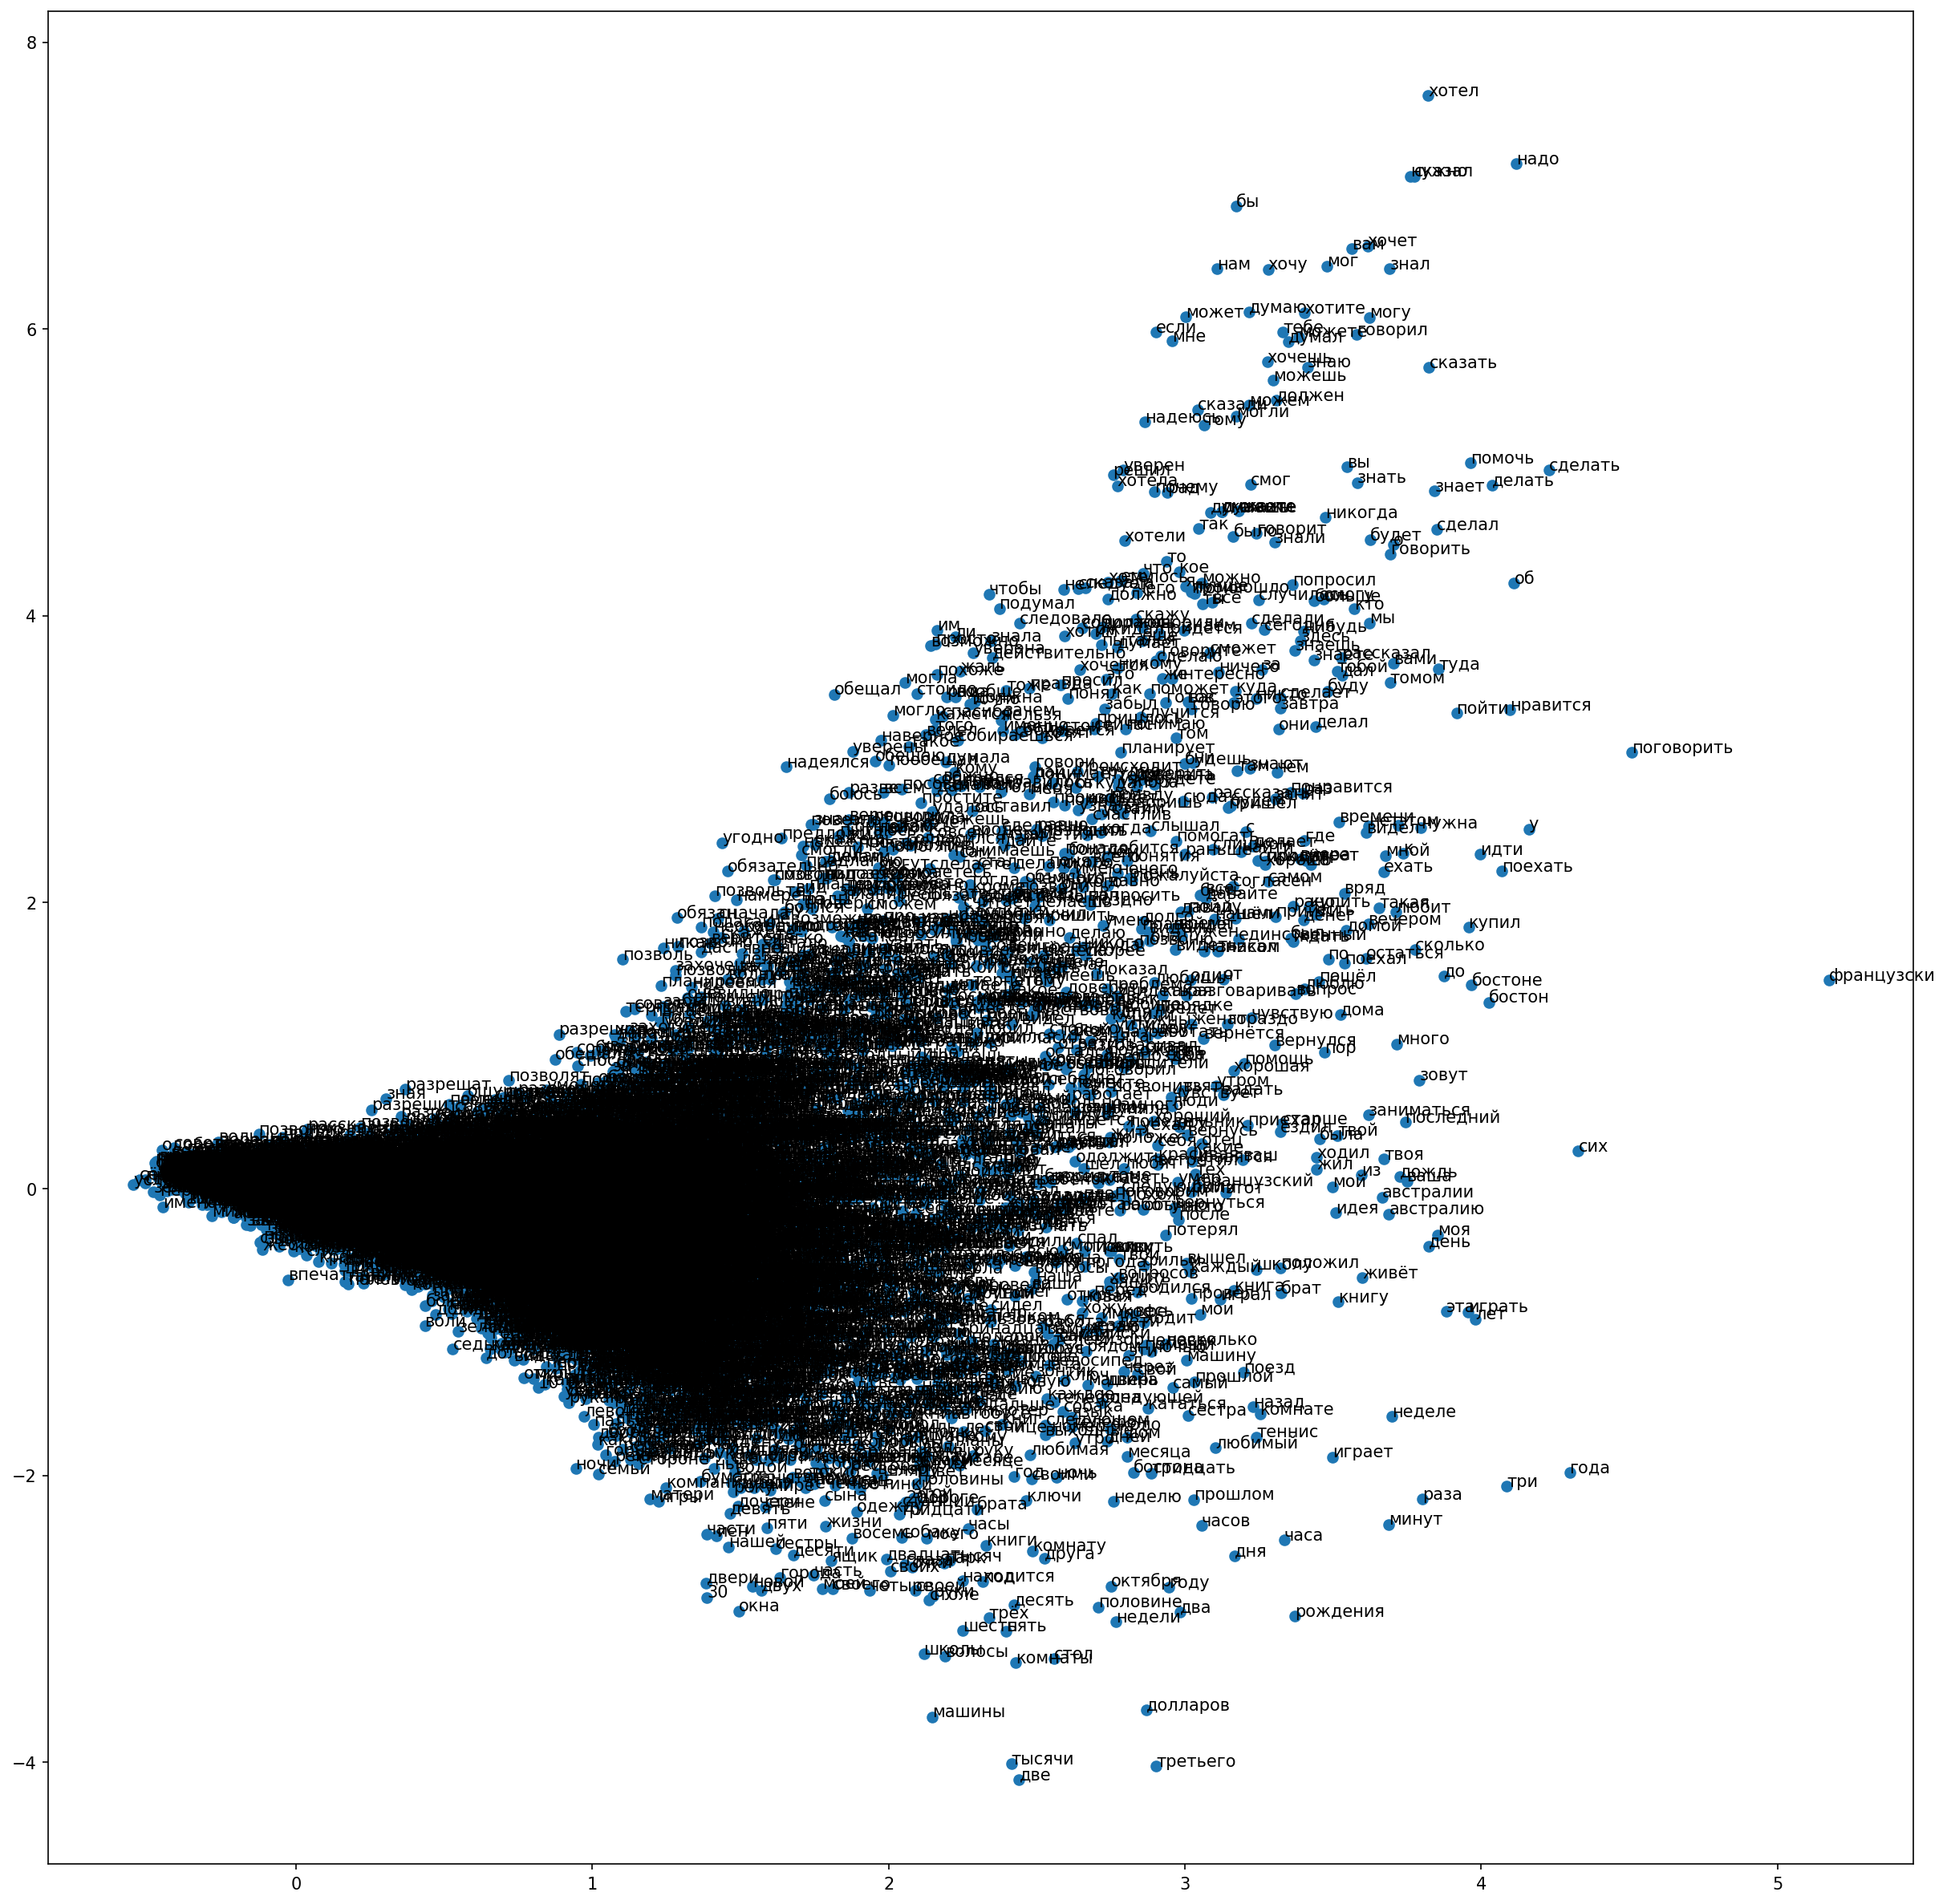

In [81]:
X = russian_model.wv[russian_model.wv.key_to_index.keys()]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(20, 20), dpi=150)
plt.scatter(result[:, 0], result[:, 1])
words = list(russian_model.wv.key_to_index.keys())
for i, word in enumerate(words):
 plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.savefig("word_embeddings_plot_Russian.png")
plt.show()

In [82]:
df.Russian

0                                                                                                                                                                                                        ['марш']
1                                                                                                                                                                                                         ['иди']
2                                                                                                                                                                                                       ['идите']
3                                                                                                                                                                                                ['здравствуйте']
4                                                                                                                                                               

In [83]:
selected_word = "экономика"
similar_words = russian_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

миссию 0.8624944686889648
признательность 0.8538030982017517
версию 0.8479957580566406
благодарность 0.8457938432693481
визитную 0.842438817024231
серьгу 0.8373298645019531
тайну 0.8337329626083374
теорию 0.8317205905914307
учётную 0.8302468061447144
позицию 0.8301417827606201


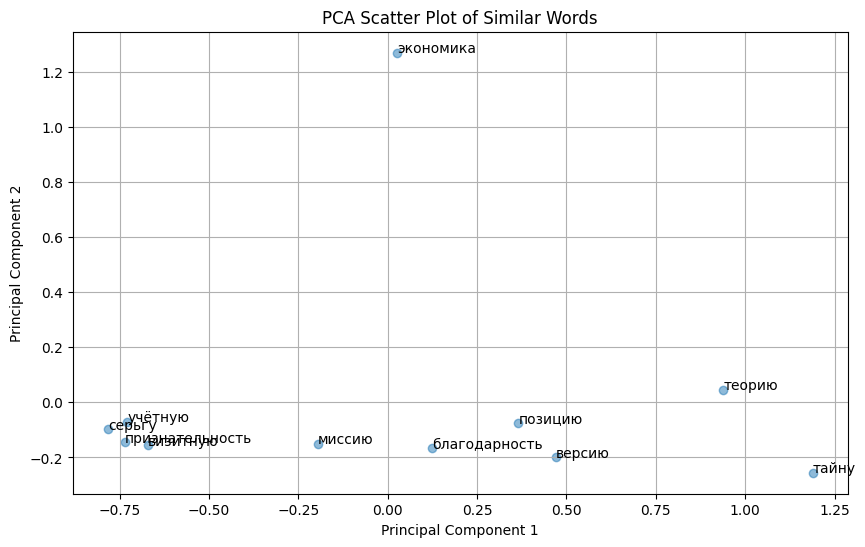

In [84]:
word_embeddings = [russian_model.wv[word] for word, _ in similar_words]
word_embeddings.append(russian_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()

In [85]:
selected_word = "момент"
similar_words = russian_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

эверест 0.9444195032119751
страховой 0.9349032640457153
крупнейшая 0.9313445687294006
лучей 0.9302640557289124
производство 0.929672360420227
веке 0.9290111660957336
северной 0.9270551204681396
являются 0.9256260991096497
восточной 0.9248054623603821
июнь 0.9238631725311279


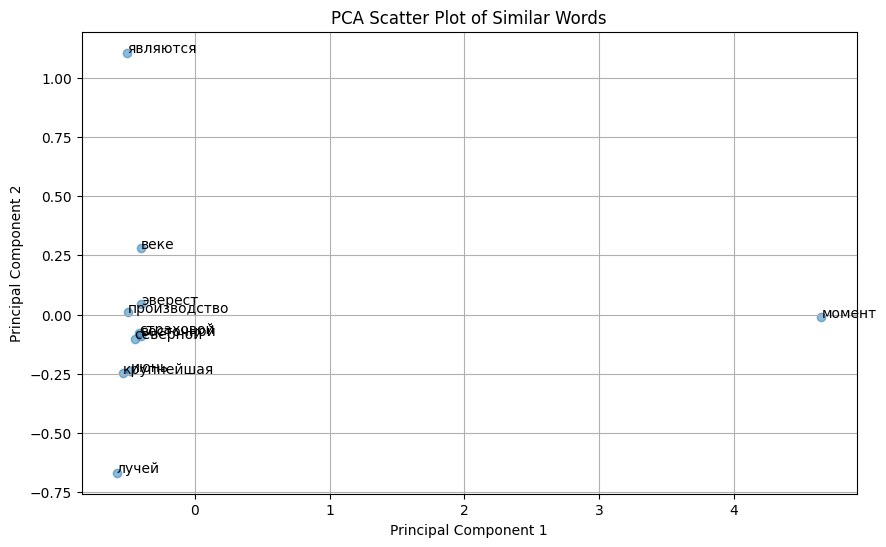

In [86]:
word_embeddings = [russian_model.wv[word] for word, _ in similar_words]
word_embeddings.append(russian_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()

In [87]:
selected_word = "когда"
similar_words = russian_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

отель 0.723242998123169
ресторан 0.713806688785553
город 0.7107560634613037
музей 0.6833004355430603
проект 0.6703832745552063
вечер 0.6682632565498352
поезд 0.6595150232315063
слог 0.6559603810310364
писк 0.6477938294410706
пункт 0.6465091705322266


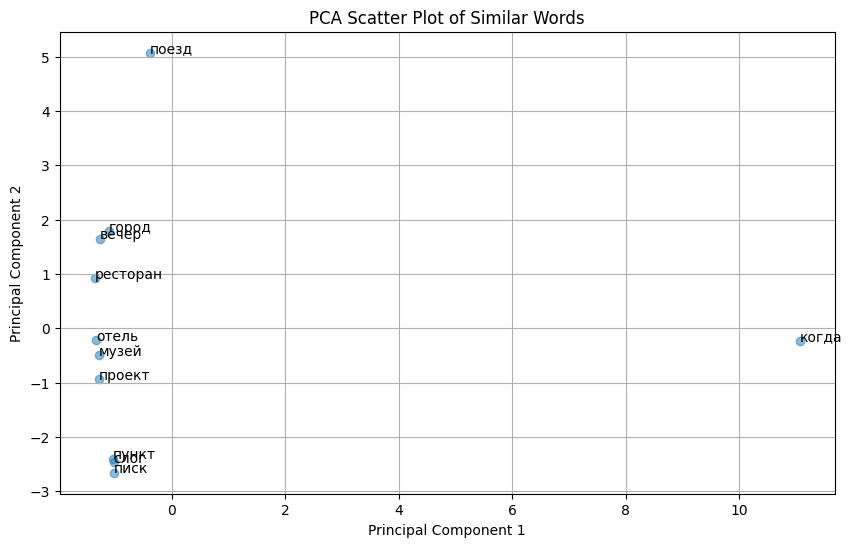

In [88]:
word_embeddings = [russian_model.wv[word] for word, _ in similar_words]
word_embeddings.append(russian_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()

In [89]:
selected_word = "мужчины"
similar_words = russian_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

наконец 0.5349822640419006
пока 0.522320568561554
как 0.5123676061630249
зачем 0.5080462694168091
если 0.5057325959205627
давно 0.5046581029891968
куда 0.49972352385520935
откуда 0.49705713987350464
тоже 0.4966486394405365
однажды 0.4883139729499817


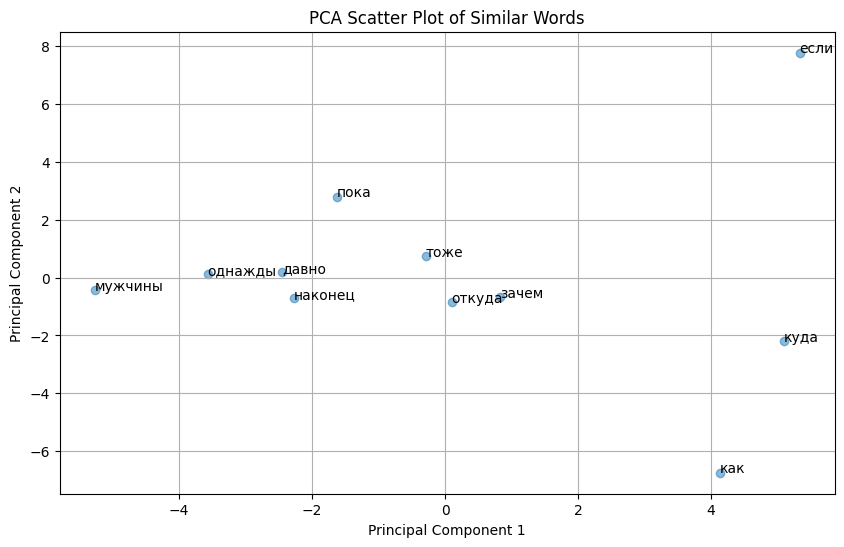

In [90]:
word_embeddings = [russian_model.wv[word] for word, _ in similar_words]
word_embeddings.append(russian_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()

In [91]:
selected_word = "растёт"
similar_words = russian_model.wv.most_similar(word, topn=10)

# Print the most similar words
for similar_word, similarity in similar_words:
    print(similar_word, similarity)

женщины 0.8817912936210632
мальчики 0.8751505017280579
студенты 0.8510097861289978
животные 0.8329063653945923
птицы 0.8188827037811279
суеверные 0.8157689571380615
остальные 0.8138363361358643
люди 0.8116461038589478
времена 0.7972604632377625
клиенты 0.7964237332344055


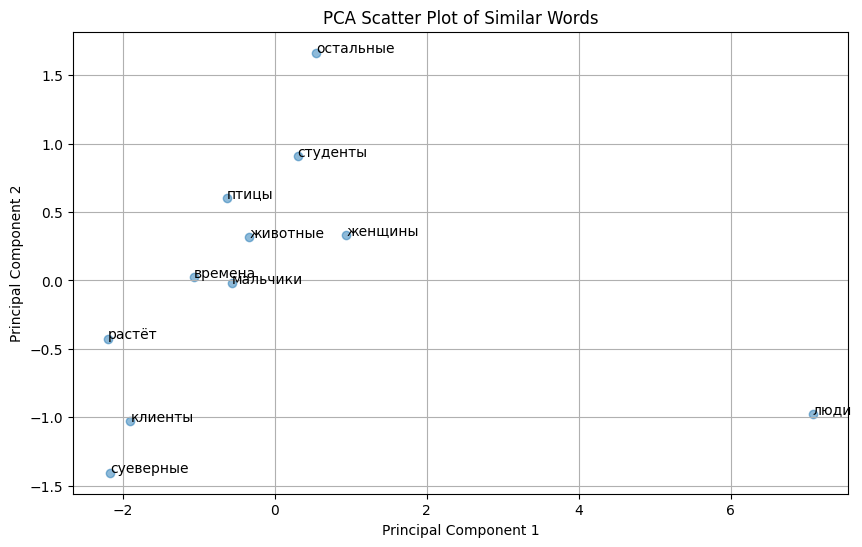

In [92]:
word_embeddings = [russian_model.wv[word] for word, _ in similar_words]
word_embeddings.append(russian_model.wv[selected_word])
words = [word for word, _ in similar_words]
words.append(selected_word)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Annotate points with words
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Similar Words')
plt.grid(True)
plt.show()